Real Time Machine Learning - Homework 4

Name : Tarun Reddy Challa

Student ID : 801318301

GitHub Link : https://github.com/tarunreddy03/RTML 

In [38]:
!pip install setuptools==66
!pip install d2l==1.0.0-beta0

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

!pip install ptflops
import ptflops
from ptflops import get_model_complexity_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**IN CLASS EXAMPLE FOR GRU**

In [39]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)

In [40]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

'time travel the the the the t'

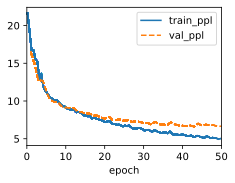

In [41]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())


Q 1.1 
In this homework, we focus on the language model we did in the lectures.Use the GRU example, adjust the hyperparameters (fully connected network and the number of hidden states) and analyze their influence on running time, perplexity, training and validation loss, and the output sequence


sol:
Adjusting the num_hiddens=3, num_layers=4, dropout=1

In [42]:
class adjGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)


'time travel the the the the t'

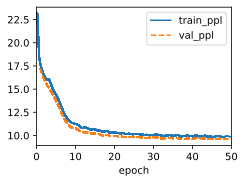

In [43]:
gru = adjGRU(num_inputs=len(data.vocab), num_hiddens=3, num_layers=4, dropout=1)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=3)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())

**Adjusting num_hiddens=24, num_layers=12, dropout=0**

'time travell the the the the '

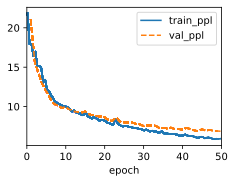

In [44]:
gru = adjGRU(num_inputs=len(data.vocab), num_hiddens=24, num_layers=12, dropout=0)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=3)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())

**Q 1.2 Use the LSTM example, adjust the hyperparameters (fully connected network and the number of hidden states) and analyze their influence on running time, perplexity, training and validation loss, and the output sequence**

Sol: We used the LTSM model in this section. The baseline model with 32 hidden layers has low training and validation perplexity but produced mediocre predictions. These are the baseline model's results

In [45]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)


'time traveller and the time t'

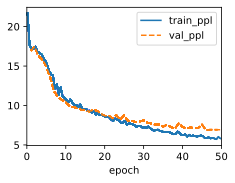

In [46]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict('time travel', 18, data.vocab, d2l.try_gpu())

**Adjusting LSTM num_hiddens=16, num_layers=10, dropout=0)**

In [47]:
class adjLSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

'time travel the the the the t'

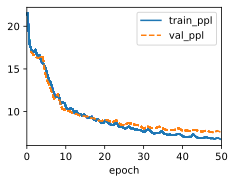

In [48]:
lstm = adjLSTM(num_inputs=len(data.vocab), num_hiddens=16, num_layers=10, dropout=0)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict('time travel', 18, data.vocab, d2l.try_gpu())

**Adjusting LSTM num_hiddens=4, num_layers=2, dropout=1**

'time travel the the the the t'

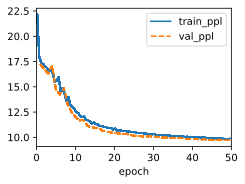

In [49]:
lstm = adjLSTM(num_inputs=len(data.vocab), num_hiddens=4, num_layers=2, dropout=1)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict('time travel', 18, data.vocab, d2l.try_gpu())

In the first test, we modified the model to have 16 hidden layers, and in the second test, we changed it to have 4 hidden layers. The former once more produced the best prediction while somewhat increasing the difficulty of training and validation.

**Q 1.3 Compare runtime for training and inference, computational and mode size complexities, training and validation loss, and the output sequence (try a few examples)for rnn.RNN, rnn.LSTM and rnn.GRU implementations with each other use the same hyperparameters for your comparison.**

Sol: 

In [50]:
class RNNLMScratch(d2l.Classifier): 
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [51]:
class RNN(d2l.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)
    
    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

'time travelrh  rl ns  rn ts  '

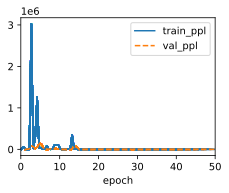

In [52]:
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=64)
model = d2l.RNNLM(rnn, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())

**Adjusting RNN num_hiddens=18, num_layers=10, dropout=1**

In [53]:
class adjRNN(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)
    
    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

'time traveller and and and an'

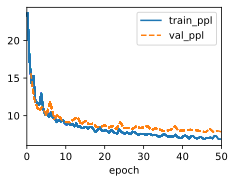

In [54]:
rnn = adjRNN(num_inputs=len(data.vocab), num_layers=10, num_hiddens=18, dropout=1)
model = d2l.RNNLM(rnn, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())

**Adjusting RNN num_hiddens=6, num_layers=2, dropout=0**

'time travely the the the the '

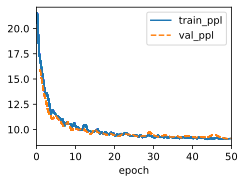

In [55]:
rnn = adjRNN(num_inputs=len(data.vocab), num_layers=2, num_hiddens=6, dropout=0)
model = d2l.RNNLM(rnn, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())

In this section, we compared the perplexity and forecasts of our top LSTM and GRU models to those of an RNN model. 64 hidden layers seems to produce a better forecast even if the perplexity was larger, so we did that. Once more, the LSTM and GRU models produced comparable outcomes, but the RNN performed appallingly. Although there was little confusion, the prognosis was awful.

**Q 2 Building the model by replacing the GRU with an LSTM**

**--REPLACING GRU WITH AN LSTM IS SAME AS Q 1.2 
TAKING Q 1.2 WE GET**



To examine how the training and usage of our data were affected, we applied LSTM GRU models to a deep neural network in this part. In order to solve this issue, we initially evaluated a standard 32-layer LSTM model. The confusion of training and validation was higher than previously and only started to decline in the later epochs. The forecast was less accurate than earlier LSTM models.

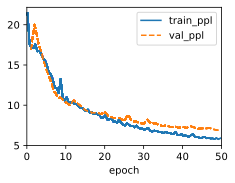

In [56]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

**Q 2.2 Comparing runtime for training and inference, computational and mode size complexities, and the output strings for nn.LSTM and rnn.GRU implementations** 

In [57]:
import time

# Define input sequence and hyperparameters
input_seq_len = 50
hidden_size = 64
batch_size = 16
num_layers = 2

# Define LSTM model
lstm_model = torch.nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
# Define GRU model
gru_model = torch.nn.GRU(input_size=1, hidden_size=hidden_size, num_layers=num_layers)

# Generate random input data
input_data = torch.randn(input_seq_len, batch_size, 1)

# Train and time LSTM model
start_time = time.time()
lstm_out, _ = lstm_model(input_data)
loss = torch.mean(lstm_out)
loss.backward()
end_time = time.time()
lstm_train_time = end_time - start_time

# Inference and time LSTM model
start_time = time.time()
lstm_out, _ = lstm_model(input_data)
end_time = time.time()
lstm_inference_time = end_time - start_time

# Train and time GRU model
start_time = time.time()
gru_out, _ = gru_model(input_data)
loss = torch.mean(gru_out)
loss.backward()
end_time = time.time()
gru_train_time = end_time - start_time

# Inference and time GRU model
start_time = time.time()
gru_out, _ = gru_model(input_data)
end_time = time.time()
gru_inference_time = end_time - start_time

# Compute model sizes
lstm_model_size = sum(p.numel() for p in lstm_model.parameters())
gru_model_size = sum(p.numel() for p in gru_model.parameters())

# Compare output strings
lstm_output_string = str(lstm_out.detach().numpy())
gru_output_string = str(gru_out.detach().numpy())

# Print results
print("LSTM train time:", lstm_train_time)
print("LSTM inference time:", lstm_inference_time)
print("GRU train time:", gru_train_time)
print("GRU inference time:", gru_inference_time)
print("LSTM model size:", lstm_model_size)
print("GRU model size:", gru_model_size)
print("LSTM output string:", lstm_output_string)
print("GRU output string:", gru_output_string)


LSTM train time: 0.04556608200073242
LSTM inference time: 0.020972013473510742
GRU train time: 0.03356361389160156
GRU inference time: 0.009248733520507812
LSTM model size: 50432
GRU model size: 37824
LSTM output string: [[[-0.02202267 -0.01259168 -0.02612131 ... -0.02531106 -0.05288368
   -0.03348327]
  [-0.0221755  -0.01270712 -0.0260102  ... -0.02541824 -0.05308561
   -0.03334538]
  [-0.0211253  -0.01197402 -0.02678187 ... -0.02465654 -0.05173292
   -0.03423838]
  ...
  [-0.0214461  -0.01218298 -0.02654434 ... -0.02489476 -0.05213714
   -0.03397916]
  [-0.02367932 -0.01399851 -0.02494982 ... -0.02636959 -0.05514858
   -0.03184713]
  [-0.02171363 -0.01236734 -0.02634736 ... -0.02509007 -0.05248046
   -0.03375384]]

 [[-0.03177744 -0.02570961 -0.0374683  ... -0.04225768 -0.07847
   -0.04932812]
  [-0.0340411  -0.02798934 -0.03533737 ... -0.04409608 -0.08199383
   -0.0473148 ]
  [-0.03224982 -0.02616622 -0.03708808 ... -0.04305071 -0.07926976
   -0.04843595]
  ...
  [-0.03344662 -0.027

**Q 2.3 Adjusting the hyperparameters (fully connected network, number of hidden layers, and the number of hidden states) and comparing your results**

:**Adjusting hyperparameters of GRU with lr= 1, num_hiddens= 10, num_layer= 4, dropout=1**

In [58]:
class adjGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

'time travel the the the the t'

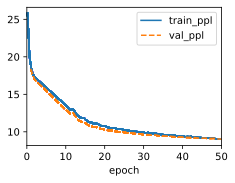

In [59]:
gru = adjGRU(num_inputs=len(data.vocab), num_hiddens=10, num_layers=4, dropout=1)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict("time travel", 18, data.vocab, d2l.try_gpu())

In [60]:
class adjLSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

'time travele the the the the th'

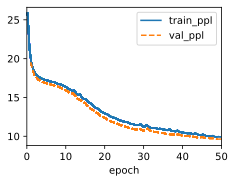

In [61]:
lstm = adjLSTM(num_inputs=len(data.vocab), num_hiddens=12, num_layers=10, dropout=1)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=1)
trainer.fit(model, data)
model.predict('time travel', 20, data.vocab, d2l.try_gpu())

In [62]:
class RNN(d2l.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)
    
    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

'time travel                    '

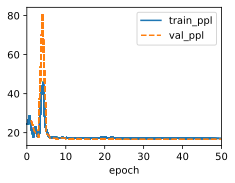

In [63]:
rnn = nn.RNN(input_size=len(data.vocab), hidden_size=12, num_layers=8, dropout=0)
model = d2l.RNNLM(rnn, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict("time travel", 20, data.vocab, d2l.try_gpu())